In [63]:
! pip install mir_eval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [115]:
import numpy as np
import os
import glob
import librosa
import random
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split

from keras import Sequential
from keras.utils import Sequence, to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import losses, models, optimizers, regularizers
from keras.activations import relu, softmax
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from tensorflow.keras import Sequential, layers
#from keras.layers import Dense, Dropout, Input, Convolution2D, BatchNormalization, Activation, MaxPool2D, Flatten
from sklearn.metrics import confusion_matrix
from keras.models import load_model

from scipy import signal

import librosa
import librosa.display

# We'll need IPython.display's Audio widget
from IPython.display import Audio

# We'll also use `mir_eval` to synthesize a signal for us
import mir_eval.sonify

# Notes 

<Figure size 1800x1080 with 0 Axes>

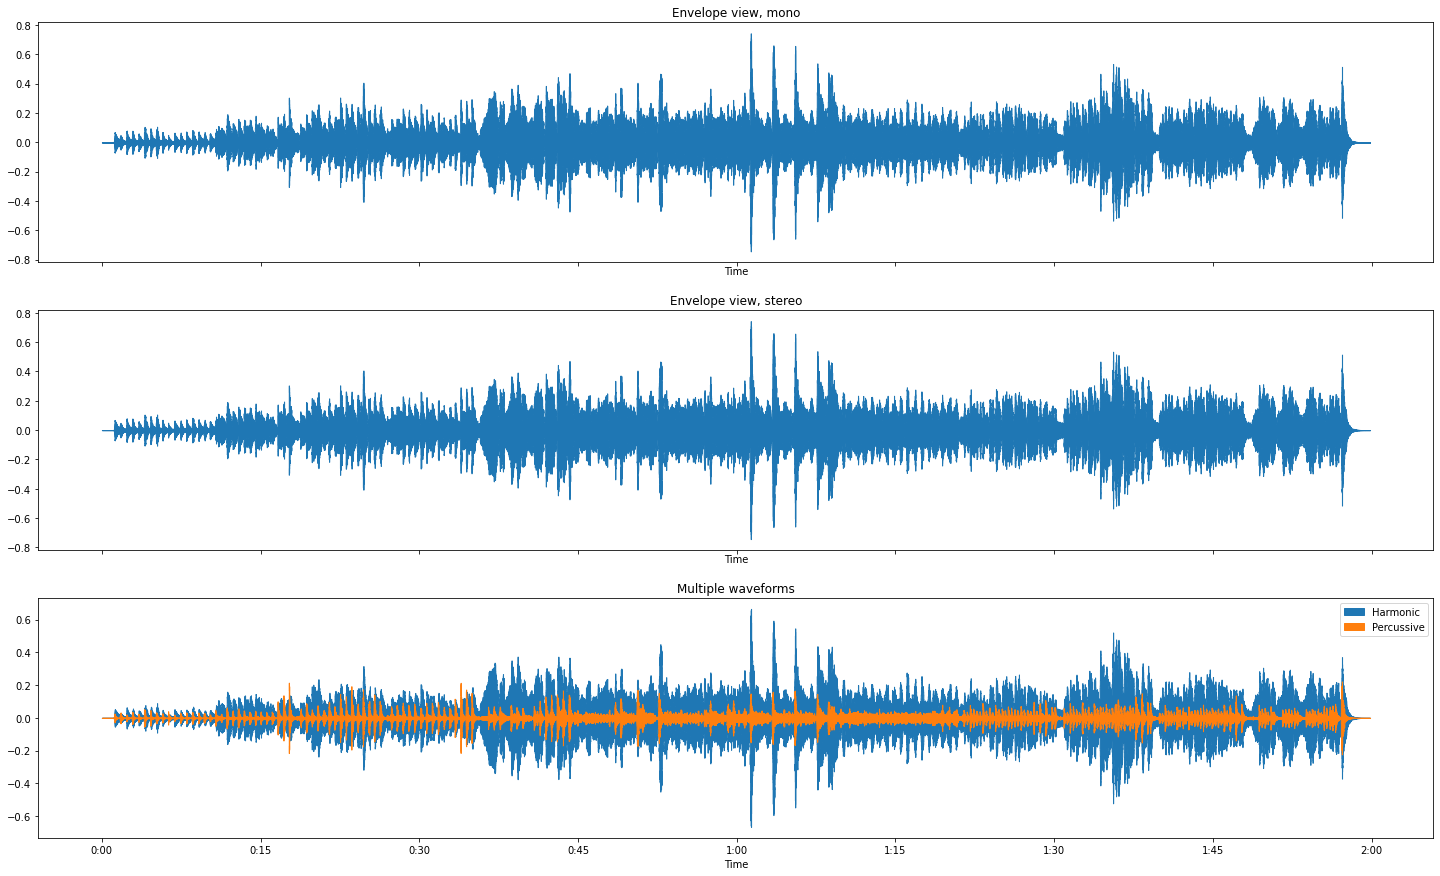

In [65]:
import traitlets
filename = librosa.example('nutcracker')
sample_rate = 22050 # this is the sample rate for playing the audio, not the actual sampling rate used to convert sound into digital 
y, sr = librosa.load(filename)
plt.figure(figsize=(25,15))
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(25,15))
librosa.display.waveshow(y, sr=sr, ax=ax[0])
librosa.display.waveshow(y, sr=sr, ax=ax[1])

#diving the audio into the prevussive and the harmonic components
y_harm, y_perc = librosa.effects.hpss(y)
librosa.display.waveshow(y_harm, sr=sr, ax=ax[2], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, ax=ax[2], label='Percussive')

ax[0].set(title='Envelope view, mono')
ax[1].set(title='Envelope view, stereo')
ax[2].set(title='Multiple waveforms')
ax[2].legend()
#Audio(data=y, rate = sample_rate)

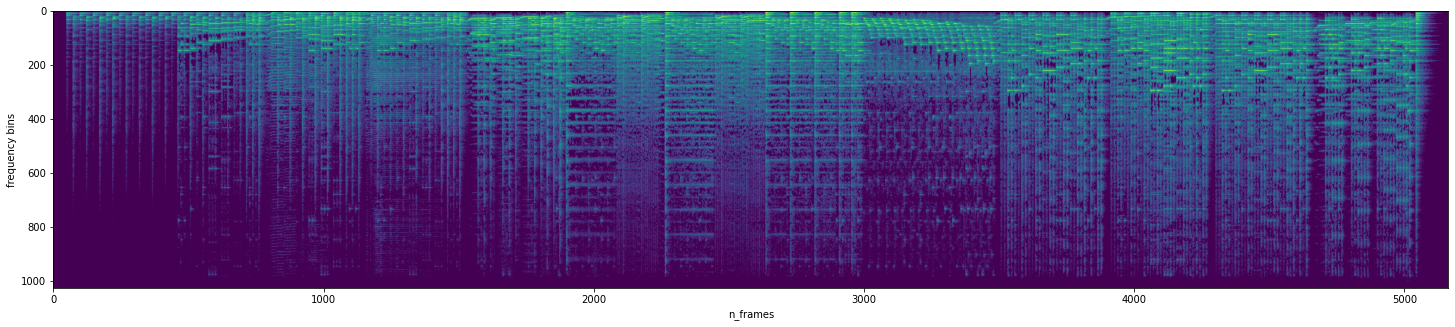

In [66]:

n_fft=2048
#outputs (num of frequency bins = 1+n_fft/2, n_frames=len(y)//hop_length)
stft=librosa.stft(y, n_fft=n_fft, hop_length=n_fft//4) #note that this is complex

#converting the complex numbers into magnitude and phase
S, phase=librosa.magphase(stft)

#convertin the magnitude in terms of dB
Sdb=librosa.amplitude_to_db(S)
#print(f'The magnitude matrix is{S}')
#print(f'The phase is {phase}')

#Display the magnitude of the stft matrix produced here.
plt.figure(figsize=(25,20))
plt.xlabel('n_frames')
plt.ylabel('frequency bins')
plt.imshow(Sdb)

# 

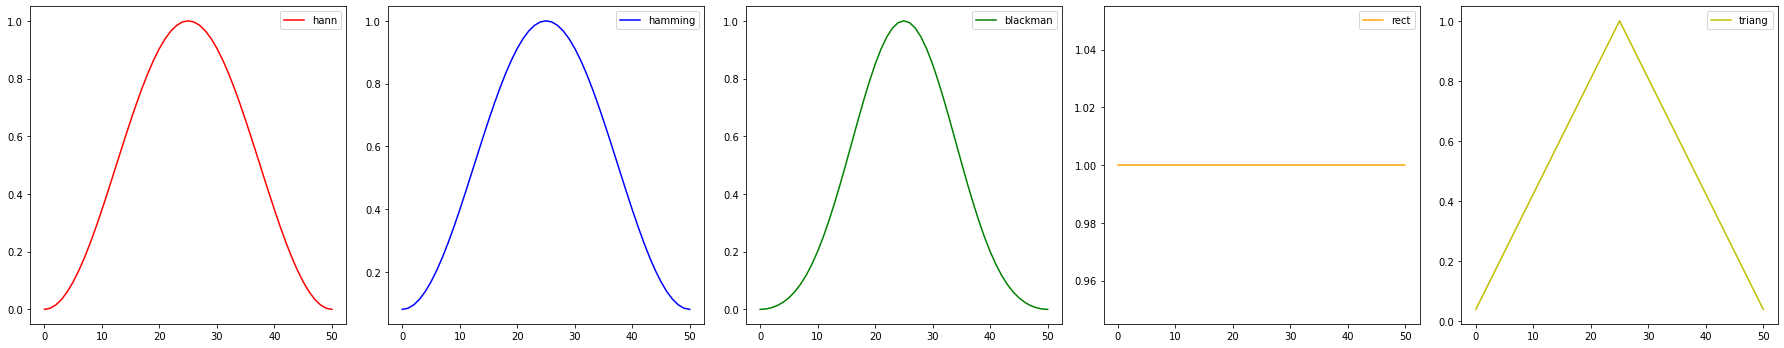

In [142]:
size=51
fig,ax=plt.subplots(1,5,figsize=(25,5))
fig.tight_layout()

ax[0].plot(signal.windows.hann(size), 'r', label='hann')
ax[1].plot(signal.windows.hamming(size), 'b', label='hamming')
ax[2].plot(signal.windows.blackman(size),'g', label='blackman')
ax[3].plot(signal.windows.boxcar(size),'orange', label='rect')
ax[4].plot(signal.windows.triang(size),'y', label='triang')

for i in range(5):
  ax[i].legend()

In [118]:
def make_segments(y,n_fft,hop_length,window_name):
  '''returns each segment of the audio'''
  
  window_type={'hann':signal.windows.hann(n_fft),
               'hamming':signal.windows.hamming(n_fft),
               'blackman':signal.windows.blackman(n_fft),
               'rect':signal.windows.boxcar(n_fft),
               'triang':signal.windows.triang(n_fft)
               }

  segment_lst=[]
  window=window_type[window_name]
  num_segments=1+(len(y)-n_fft)//hop_length
  for k in range(num_segments):
    start=k*hop_length
    end=start+n_fft
    segment=y[start:end]
    segment=segment*window
    segment_lst.append(segment)
  return segment_lst

In [120]:
frames=make_segments(y=y,n_fft=2048,hop_length=n_fft//4, window_name='hann')
len(frames[1])

2048

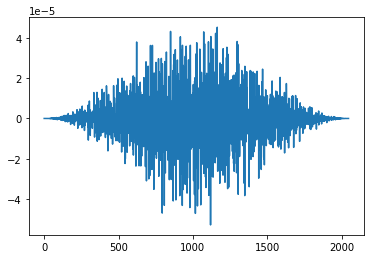

In [114]:
plt.plot(frames[2])

In [46]:
#Implementing the Short term fourier transform from scratch 
def STFT(signal, n_fft, hop_length):
  '''Return a matrix with time bins in the row direction, and
  frequency bins in the column direction'''
  #step1: divide the signal into smaller segments
  n_segments=len(signal)//n_fft

  #crate the storage for the data
  fq_bins=1+n_fft//2
  time_bins=signal.shape[0]//hop_length + 1
  data=np.zeros((fq_bins,time_bins))

  #num_segments=len(signal)//n_fft
  for i in range(time_bins):
    start=i*hop_length
    end=start+n_fft//2 + 1
    segment_signal=signal[start:end]*np.hanning(len(signal[start:end]))
    signal_fft=np.fft.fft(segment_signal)
    #print(len(signal_fft))
    if len(signal_fft)!=fq_bins:
      pad=np.zeros(fq_bins)
      pad[:len(signal_fft)]=signal_fft
      data[:,i]=pad
    else:
      data[:,i]=signal_fft

  return data


In [61]:
def spectrogram(stft):
  stft_mag=np.abs(stft)
  spec=20*np.log10(stft)
  #spec=np.clip(spec,-40,200)
  return spec

In [62]:
filename = librosa.example('nutcracker')
sample_rate = 22050 # this is the sample rate for playing the audio, not the actual sampling rate used to convert sound into digital
n_fft=2048
hop_length=n_fft//4 
y, sr = librosa.load(filename)
mat = STFT(signal=y, n_fft=n_fft, hop_length=hop_length)
spectrogram(mat)

<ipython-input-46-052643991c3e>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  data[:,i]=signal_fft
<ipython-input-46-052643991c3e>:22: ComplexWarning: Casting complex values to real discards the imaginary part
  pad[:len(signal_fft)]=signal_fft
<ipython-input-61-dd3a1b3c6492>:3: RuntimeWarning: divide by zero encountered in log10
  spec=20*np.log10(stft)
<ipython-input-61-dd3a1b3c6492>:3: RuntimeWarning: invalid value encountered in log10
  spec=20*np.log10(stft)


array([[-160.88511842, -179.88371462, -156.07227554, ..., -143.02711093,
        -134.63553208,           nan],
       [          nan, -165.05431063, -161.65639954, ...,           nan,
        -143.98086674,           nan],
       [          nan, -172.13042833, -158.70288445, ...,           nan,
        -133.82278686,           nan],
       ...,
       [          nan, -173.17755122, -158.96910045, ..., -142.17567636,
                 -inf,          -inf],
       [          nan, -172.13042833, -158.70288445, ...,           nan,
                 -inf,          -inf],
       [          nan, -165.05431063, -161.65639954, ...,           nan,
                 -inf,          -inf]])

# Speech Recognition

In [ ]:
signal=

In [66]:
(22050/(2048//4))*1000

43066.40625

10.75609756097561

In [60]:
stft.shape #outputs (1+n_fft/2, 22050)

(1025, 5163)

In [21]:
#Get the duration of how long the audio is 
duration = librosa.get_duration(y=y, sr=22050, S=None, n_fft=2048, hop_length=512)
print(f'duration of the audio is {duration}')

# The number of points in the audio, this will return the length of y 
print(duration * sample_rate)

duration of the audio is 119.87591836734694
2643264.0


In [29]:
mag_y = np.abs(librosa.stft(y))

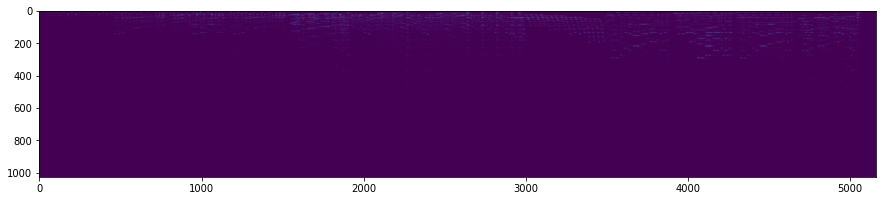

In [33]:
plt.figure(figsize=(15,10))
plt.imshow(mag_y)

In [10]:
librosa.get_duration(y)

119.87591836734694

In [11]:
sr = 22050

y_sweep = librosa.chirp(fmin=librosa.note_to_hz('C3'),
                        fmax=librosa.note_to_hz('C5'),
                        sr=sr,
                        duration=1)

Audio(data=y_sweep, rate=sr)

In [12]:
y, sr = librosa.load(librosa.ex('trumpet'))

Audio(data=y, rate=sr)

In [13]:
# Using fill_na=None retains the best-guess f0 at unvoiced frames
f0, voiced_flag, voiced_probs = librosa.pyin(y,
                                             sr=sr,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'),
                                             fill_na=None)

# To synthesize the f0, we'll need sample times
times = librosa.times_like(f0)

In [14]:
vneg = (-1)**(~voiced_flag)

# And sonify the f0 using mir_eval
y_f0 = mir_eval.sonify.pitch_contour(times, f0 * vneg, sr)

Audio(data=y_f0, rate=sr)


In [15]:
# Compute the onset strength envelope, using a max filter of 5 frequency bins
# to cut down on false positives
onset_env = librosa.onset.onset_strength(y=y, sr=sr, max_size=5)

# Detect onset times from the strength envelope
onset_times = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr, units='time')

# Sonify onset times as clicks
y_clicks = librosa.clicks(times=onset_times, length=len(y), sr=sr)

Audio(data=y+y_clicks, rate=sr)